In [1]:
import torch

import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd
import seaborn

import sys
import time
import os
from math import log
import random
from tqdm import tqdm

from rdkit.Chem import MolFromSmiles, MolToSmiles, RDConfig
from rdkit.Chem.Crippen import MolLogP as LogP
from rdkit.Chem.QED import qed as QED
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
from sascorer import calculateScore as SAS

from utils.utils import *
from utils.dataset import *
from models.MixedNN import Encoder, Decoder, Predictor

%load_ext autoreload
%autoreload 2

In [2]:
DATADIR = './data/gdb13-augmented/'
RUNDIR = './runs/train16-64/'
DATASPEC_FILE = os.path.join(DATADIR, 'spec.json')
RUNSPEC_FILE = os.path.join(RUNDIR, 'spec.json')

encoder_weights_file = os.path.join(RUNDIR, 'encoder_weights.pth')
decoder_weights_file = os.path.join(RUNDIR, 'decoder_weights.pth')
predictor_weights_file = os.path.join(RUNDIR, 'predictor_weights.pth')

dataspec = fetch_params(DATASPEC_FILE)
runspec = fetch_params(RUNSPEC_FILE)

to_indices, from_distribution = make_embed_utils(dataspec)

### Models

In [3]:
kwargs = {
    'L': runspec.L, 
    'alphabet_len': len(dataspec.alphabet), 
    'smile_len': dataspec.smile_len
}

encoder = Encoder(**kwargs)
encoder.load_state_dict(torch.load(RUNDIR + 'encoder_weights.pth', map_location=torch.device('cpu')))
encoder.eval()

predictor = Predictor(**kwargs)
predictor.load_state_dict(torch.load(RUNDIR + 'predictor_weights.pth', map_location=torch.device('cpu')))
predictor.eval()

decoder = Decoder(**kwargs)
decoder.load_state_dict(torch.load(RUNDIR + 'decoder_weights.pth', map_location=torch.device('cpu')))
decoder.eval()

print(f'Encoder: {sum(p.numel() for p in encoder.parameters())} parameters')
print(f'Predictor: {sum(p.numel() for p in predictor.parameters())} parameters')
print(f'Decoder: {sum(p.numel() for p in decoder.parameters())} parameters')

Encoder: 1990680 parameters
Predictor: 7427 parameters
Decoder: 229408 parameters


### Data

In [4]:
trainset, testset = make_data(DATADIR, to_indices, n=1000)

### Important Dimensions

64 Variant Dimensions:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


Text(0.5, 0, 'dimension')

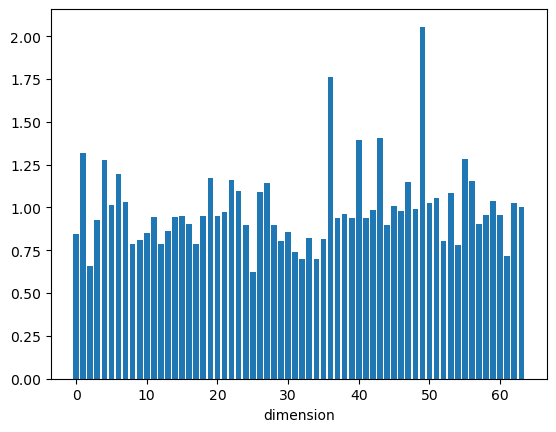

In [5]:
means, stds = get_latent_distributions(encoder, testset.hots)

# Standard Deviation
variant_dimensions = [i for i, std in enumerate(stds) if std > 0.05]
print(f'{len(variant_dimensions)} Variant Dimensions: ', variant_dimensions)
plt.bar(range(runspec.L), stds.detach())
plt.xlabel('variance')
plt.xlabel('dimension')

# Loss
#dims = get_important_dimensions(trainset.hots, encoder=encoder, decoder=decoder, use_loss=True)
#print(f'{len(dims)} Sensitive Dimensions: ', dims)

### Property Prediction

In [ ]:
%%capture --no-display

n = 64

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4))

x, logp, qed, sas = testset.sample(n)
z, _, _ = encoder(x)
logp_hat, qed_hat, sas_hat = predictor(z)

ax0.scatter(logp.detach(), logp_hat.detach(), s=1, alpha=0.5)
ax0.set_xlim([-5, 5])
ax0.set_ylim([-5, 5])
ax0.set_title('logp')

ax1.scatter(qed.detach(), qed_hat.detach(), s=1, alpha=0.5)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_title('qed')

ax2.scatter(sas.detach(), sas_hat.detach(), s=1, alpha=0.5)
ax2.set_xlim([0, 10])
ax2.set_ylim([0, 10])
ax2.set_title('sas')

means, stds = get_latent_distributions(encoder, testset.hots)
i = 0
while i < n:
    z = torch.normal(means, stds).unsqueeze(0)
    smile = from_distribution(decoder(z))[0]
    
    mol = MolFromSmiles(smile)
    if mol is not None:
        logp, qed, sas = predictor(z)
        logp_hat, qed_hat, sas_hat = LogP(mol), QED(mol), SAS(mol)
        
        ax0.scatter(float(logp), logp_hat, color='red', s=2)
        ax1.scatter(float(qed), qed_hat, color='red', s=2)
        ax2.scatter(float(sas), sas_hat, color='red', s=2)
        
        i += 1

### Diversity and Validity

In [ ]:
%%capture

stds = [float(std) for std in list(stds)]

dim1 = dims[0]
dim1_n = 10

dim2 = dims[3]
dim2_n = 10

x = testset.sample(1)
sample_smile = from_hot(x, dataspec.alphabet)[0]
print(sample_smile)
z, _, _ = encoder(x)

dim1_values = torch.arange(start=-stds[dim1], end=stds[dim1], step=(2*stds[dim1])/dim1_n) + z[:, dim1]
dim2_values = torch.arange(start=-stds[dim2], end=stds[dim2], step=(2*stds[dim2])/dim2_n) + z[:, dim2]
dim1_values = dim1_values.detach()
dim2_values = dim2_values.detach()

res = torch.empty((dim1_values.size(0), dim2_values.size(0)))

for i, v1 in enumerate(dim1_values):
    for j, v2 in enumerate(dim2_values):
        z[:, dim1] = v1
        z[:, dim2] = v2
        
        smile = from_hot(decoder(z), dataspec.alphabet)[0]

        mol = MolFromSmiles(smile)
        
        if mol:
            if smile == sample_smile: res[i, j] = 2
            else: res[i, j] = 1
        else:
            res[i, j] = 0

In [ ]:
%%capture

smiles = set()
invalid = 0

n = 1000

for i in range(n):
    z = torch.normal(means, stds).unsqueeze(0)
    x_hat = decoder(z)
    smile = from_hot(x_hat, dataspec.alphabet)[0].replace('L', 'Cl')
    
    mol = MolFromSmiles(smile)
    
    if mol:
        smile = MolToSmiles(mol)
        smiles.add(smile)
    else:
        invalid += 1
    
    clear_output()

In [ ]:
print('Diversity:\t', len(smiles)/(n - invalid))
print('Proportion Valid:\t', 1 - invalid/n)

### Latent Space Property Smoothness

In [ ]:
predictor.eval()

z, _, _ = encoder(testset.sample(1))
z = z.squeeze()

dim = 0

#interval = torch.randn(1000) * stds[dim] + means[dim]

logps = []
qeds = []
sass = []

mean = float(means[dim])
std = float(stds[dim])

interval = torch.arange(start=mean-3*std, end=mean+3*std, step=2*std/1000)

for d in interval:
    z[dim] = d

    logp, qed, sas = predictor(z.unsqueeze(0))
    
    logps.append(float(logp))
    qeds.append(float(qed))
    sass.append(float(sas))

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True)
ax0.scatter(interval, logps, s=0.1)
ax1.scatter(interval, qeds, s=0.1)
ax2.scatter(interval, sass, s=0.1)